# `MeshArrays.Interpolate` To Arbitrary Coordinates

A `MeshArray` is a collection of arrays that collectively form a global domain grid. Here we interpolate from the global grid to a set of arbitary locations as is commonly done e.g. to compare climate models to sparse field observations. 

```
(f,i,j,w,_,_,_)=InterpolationFactors(Γ,vec(lon),vec(lat))
Depth_interpolated=Interpolate(Γ.Depth,f,i,j,w)
```

This notebook breaks down the `MeshArray.Interpolate` function, normally called as shown here. In brief, the program finds a grid point quadrilateral (4 grid points) that encloses each chosen location. Computation is chuncked in subdomains (tiles) to allow for parallelism. `MeshArrays.InterpolationFactors` outputs interpolation coefficients -- reusing those is easy and fast, as shown here.

## Initialize Framework

1. import `MeshArrays` and plotting tools
2. choose e.g. a standard `MITgcm` grid
3. download the grid if needed


In [1]:
using MeshArrays, MITgcmTools, Plots

pth=MeshArrays.GRID_LLC90
γ=GridSpec("LatLonCap",pth)
Γ=GridLoad(γ;option="full");

## Choose Target Coordinates And Interpolate

In [2]:
lon=collect(0.1:0.5:2.1); lat=collect(0.1:0.5:2.1);
#lon=[66.75]; lat=[-69.75];

(f,i,j,w,_,_,_)=InterpolationFactors(Γ,vec(lon),vec(lat))
Depth_int=Interpolate(Γ.Depth,f,i,j,w)

5-element Vector{Float64}:
 4876.487325787408
 4820.3955172340175
 4739.044206160812
 4615.540961175306
 4466.880392141819

## The Interpolation Code? Let's Break It Down:

- find nearest neighbor (`MeshArray` & `set`)
- define subdomain tiles (`MeshArray` -> `tiles`)
- exchange and start loop (`tile` & `subset`)
    - local stereographic projection
    - define array of quadrilaterals
    - find enclosing quadrilaterals
    - compute interpolation coefficients

### Find Nearest Neighbor

In [3]:
(f,i,j,c)=knn(Γ.XC,Γ.YC,lon,lat)
[write(Γ.XC)[c] write(Γ.YC)[c]]

5×2 Matrix{Float64}:
 0.5  0.199365
 0.5  0.602104
 1.5  1.01667
 1.5  1.4512
 2.5  1.91446

### Define Subdomain Tiles

_(as done in `InterpolationFactors`)_

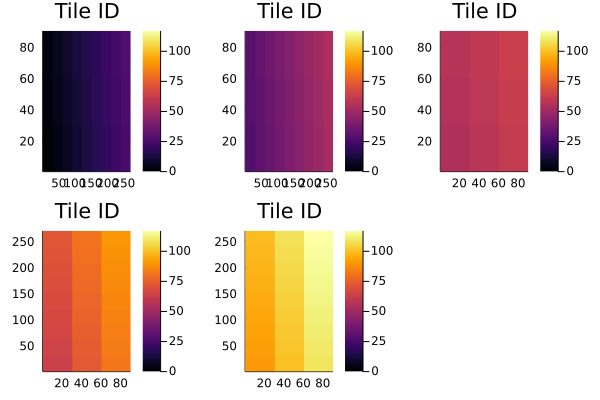

In [4]:
ni=30; nj=30;
τ=Tiles(γ,ni,nj)

tiles=MeshArray(γ,Int);
[tiles[τ[i].face][τ[i].i,τ[i].j].=i for i in 1:length(τ)];

import Plots: heatmap
function heatmap(x::MeshArray; args...)
    n=x.grid.nFaces
    p=()
    for i=1:n; p=(p...,heatmap(x[i]; args...)); end
    plot(p...)
end

heatmap(tiles,title="Tile ID",clims=(0,length(τ)))

### Example Setup

Hereafter we depict the interpolation problem setup:

1. in geographic coordinates. 
2. in the local stereographic coordinates used for interpolation.

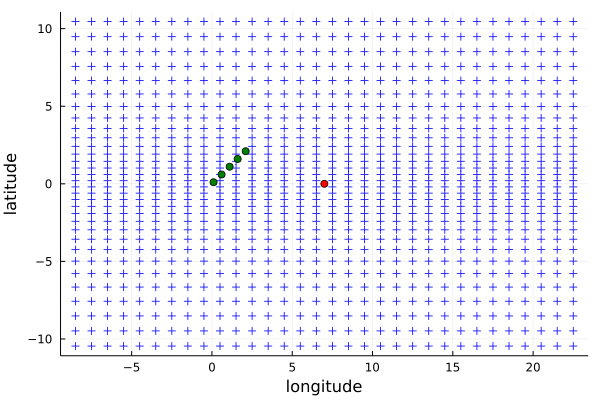

In [5]:
XCtiles=Tiles(τ,exchange(Γ.XC))
YCtiles=Tiles(τ,exchange(Γ.YC))

iiTile=tiles[f[1]][i[1],j[1]]; iiFace=τ[iiTile].face

ii0=minimum(τ[iiTile].i)+Int(ni/2); jj0=minimum(τ[iiTile].j)+Int(nj/2)
XC0=Γ.XG.f[iiFace][ii0,jj0]; YC0=Γ.YG.f[iiFace][ii0,jj0]
#XC0=66.5000; YC0=-64.4201

scatter(XCtiles[iiTile],YCtiles[iiTile],marker=:+,c=:blue,leg=false,xlabel="longitude",ylabel="latitude")
scatter!([XC0],[YC0],c=:red); scatter!([lon],[lat],c=:green)

### Projection, Quadrilaterals, & Coefficients

_(as done in `InterpolationFactors`)_

In [6]:
#Local Stereographic Projection
(x_grid,y_grid)=StereographicProjection(XC0,YC0,XCtiles[iiTile],YCtiles[iiTile])
(x_trgt,y_trgt)=StereographicProjection(XC0,YC0,lon,lat)
~isa(x_trgt,Array) ? x_trgt=[x_trgt] : nothing
~isa(y_trgt,Array) ? y_trgt=[y_trgt] : nothing

#Identify Enclosing Quadrilaterals
(x_quad,y_quad,i_quad,j_quad)=MeshArrays.QuadArrays(x_grid,y_grid)
angsum=zeros(size(x_quad,1),size(x_trgt,1))
MeshArrays.PolygonAngle(x_quad,y_quad,x_trgt,y_trgt,angsum)
ii=findall(angsum.>180.)
ii=[ii[j].I[1] for j in 1:length(ii)]

#Interpolation Coefficients
px=permutedims(x_quad[ii[1],:]); py=permutedims(y_quad[ii[1],:])
ox=x_trgt[1]; oy=y_trgt[1]; ow=zeros(4)
MeshArrays.QuadCoeffs(px,py,ox,oy,ow);

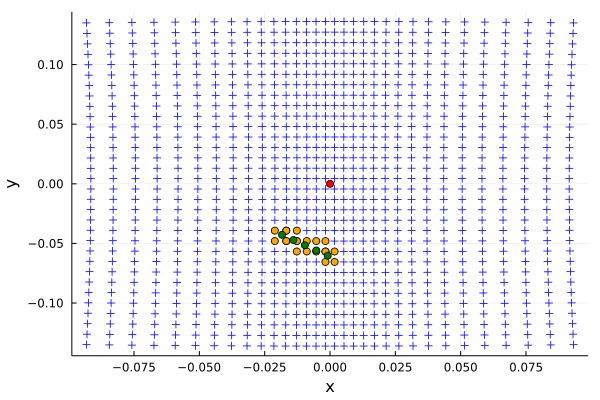

In [7]:
scatter(x_grid,y_grid,marker=:+,c=:blue,leg=false,xlabel="x",ylabel="y")
scatter!([0.],[0.],c=:red); scatter!(x_quad[ii,:],y_quad[ii,:],c=:orange)
scatter!(x_trgt,y_trgt,c=:green)

### Putting It All Together

Here we just call `InterpolationFactors`. We then interpolate longitude and latitude using the pre-computed coefficients and compare with initial `XC,YC` as a verification.

In [8]:
(f,i,j,w)=InterpolationFactors(Γ,lon,lat)

lon_a=NaN*similar(lon)
lat_a=NaN*similar(lat)
for jj=1:length(lon)
    if !isnan(sum(w[jj,:]))
        x=[Γ.XC[f[jj,ii]][i[jj,ii],j[jj,ii]] for ii=1:4]
        y=[Γ.YC[f[jj,ii]][i[jj,ii],j[jj,ii]] for ii=1:4]
        lon_a[jj]=sum(w[jj,:].*x)
        lat_a[jj]=sum(w[jj,:].*y)
    end
end

#or equivalently:
lon_b=Interpolate(Γ.XC,f,i,j,w)
lat_b=Interpolate(Γ.YC,f,i,j,w)

5-element Vector{Float64}:
 0.10039494182706254
 0.6001641682511889
 1.1003748042505725
 1.6000645160211295
 2.1002943635772144

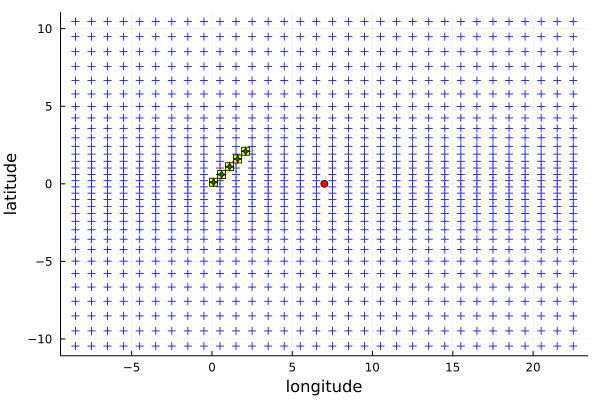

In [9]:
scatter(XCtiles[iiTile],YCtiles[iiTile],marker=:+,c=:blue,leg=false,xlabel="longitude",ylabel="latitude")
scatter!([XC0],[YC0],c=:red); scatter!(lon_a,lat_a,c=:yellow,marker=:square)
scatter!(lon,lat,c=:green,marker=:star4)

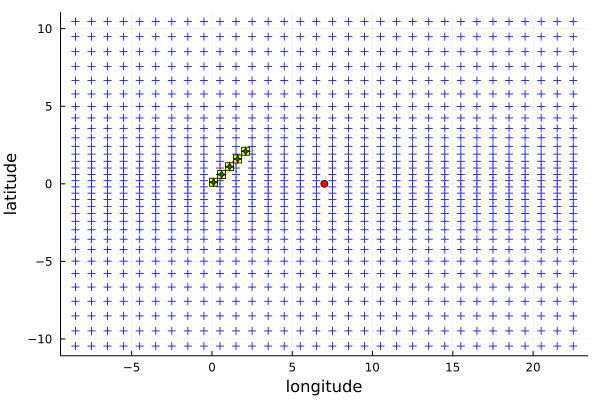

In [10]:
#or equivalently:

lon_c=similar(lon)
lat_c=similar(lat)
for jj=1:length(lon)
    x=[XCtiles[iiTile][i_quad[ii[jj],i]+1,j_quad[ii[jj],i]+1] for i=1:4]
    y=[YCtiles[iiTile][i_quad[ii[jj],i]+1,j_quad[ii[jj],i]+1] for i=1:4]
    lon_c[jj]=sum(x.*w[jj,:])
    lat_c[jj]=sum(y.*w[jj,:])
end

scatter(XCtiles[iiTile],YCtiles[iiTile],marker=:+,c=:blue,leg=false,xlabel="longitude",ylabel="latitude")
scatter!([XC0],[YC0],c=:red); scatter!(lon_c,lat_c,c=:yellow,marker=:square)
scatter!(lon,lat,c=:green,marker=:star4)